In [1]:
#importing all the necessary libraries.
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#importing the initial data from the file "Mallards_initial data.xlsx"
mallards=pd.read_excel("Mallards_initial data.xlsx")
#The line bellow is used for debugging.
mallards = mallards.loc[:, ~mallards.columns.str.contains('^Unnamed')]
print(mallards.tail(5))

       population  farmed       date       hour  slatitude  slongitude
19910         111       0 2012-10-03   18:46:46  56.440178   13.992034
19911         111       0 2012-10-03   19:46:42  56.439957   13.992407
19912         111       0 2012-10-03   20:47:04  56.440022   13.992071
19913         111       0 2012-10-03   21:49:33  56.440029   13.992332
19914         111       0 2012-10-03   22:48:59  56.440067   13.993050


In [3]:
# instead of any other type of grouping we choose to group the mallards by ordering them by population.
ordered = mallards.sort_values(by=["population"]).reset_index(drop=True)

In [4]:
ordered.tail(10)

,population,farmed,date,hour,slatitude,slongitude
19905,153,1,2012-10-19,04:39:28,56.500893,13.970902
19906,153,1,2012-10-19,05:39:21,56.500786,13.970841
19907,153,1,2012-10-19,06:38:23,56.500889,13.971055
19908,153,1,2012-10-19,07:38:58,56.487541,13.965097
19909,153,1,2012-10-19,08:39:03,56.487274,13.965044
19910,153,1,2012-10-19,09:39:15,56.487392,13.965101
19911,153,1,2012-10-19,10:38:33,56.487503,13.965265
19912,153,1,2012-10-19,11:38:27,56.487041,13.965001
19913,153,1,2012-10-18,07:41:34,56.487537,13.965165
19914,153,1,2012-10-08,07:59:45,56.432728,13.989956


In [5]:
#Saving the ordered by population data into the Excel file "mallards_ordered.xlsx"
ordered.to_excel("mallards_ordered.xlsx", index=False)

In [6]:
#Creating the dataframe that is going to be used as y. Each column will be used as y in a different model.
labelled = pd.DataFrame(columns=["dlatitude", "dlongitude"])

#Generating the labels by making the next coordinates as the destination coordinates for the previous row.
for i, row in ordered.iterrows():
    if i == ordered.index[-1]:
        break
    if row["population"] != ordered.iloc[i+1]["population"]:
        label_row = pd.DataFrame({"dlatitude": row["slatitude"], "dlongitude": row["slongitude"]}, index=[i])
    else:
        label_row = pd.DataFrame({"dlatitude": ordered.iloc[i+1]["slatitude"], "dlongitude": ordered.iloc[i+1]["slongitude"]}, index=[i])
    labelled = pd.concat([labelled, label_row])


In [7]:
labelled.head(10)

,dlatitude,dlongitude
0,56.439716,13.991791
1,56.440170,13.992670
2,56.440136,13.992191
3,56.441143,13.988527
4,56.439919,13.991972
5,56.439869,13.992161
6,56.439716,13.992242
7,56.439934,13.991963
8,56.439888,13.992043
9,56.440109,13.991787


In [8]:
# drop last two rows from ordered dataframe. It is used for data management.
ordered = ordered.iloc[:-2].reset_index(drop=True)

# drop last row from labelled dataframe. It is used for data management.
labelled = labelled.iloc[:-1].reset_index(drop=True)

In [9]:
print(ordered.iloc[:-1].shape)

(19912, 6)


In [10]:
print(labelled["dlatitude"].iloc[:-1].shape)

(19912,)


In [11]:
# Making different splits for different models, one for longitude and one latitude.
X_train, X_test, y_lat_train, y_lat_test = train_test_split(
    ordered.iloc[:-1], labelled["dlatitude"].iloc[:-1], test_size=0.2, random_state=42
)
X_train, X_test, y_long_train, y_long_test = train_test_split(
    ordered.iloc[:-1], labelled["dlongitude"].iloc[:-1], test_size=0.2, random_state=42
)

In [12]:
X_train.shape

(15929, 6)

In [13]:
# We use standard scaler to do our scalling, instead of manual scaling.
scaler = StandardScaler()

In [14]:
# Making sure that date and hour have the necessary format.
X_train_no_date = X_train.drop(['date', 'hour'], axis=1)
X_train_scaled = scaler.fit_transform(X_train_no_date)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_no_date.columns, index=X_train_no_date.index)
X_train_scaled_df[['date', 'hour']] = X_train[['date', 'hour']]

In [15]:
# Making sure that date and hour have the necessary format.
X_test_no_date = X_test.drop(['date', 'hour'], axis=1)
X_test_scaled = scaler.transform(X_test_no_date)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_no_date.columns, index=X_test_no_date.index)
X_test_scaled_df[['date', 'hour']] = X_test[['date', 'hour']]

In [16]:
# extract day of the week and hour of the day from datetime columns
X_train_scaled_df['weekday'] = X_train_scaled_df['date'].dt.weekday
X_train_scaled_df['hour'] = pd.to_datetime(X_train_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_train_scaled_df['hour'] = X_train_scaled_df['hour'].dt.hour

X_test_scaled_df['weekday'] = X_test_scaled_df['date'].dt.weekday
X_test_scaled_df['hour'] = pd.to_datetime(X_test_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_test_scaled_df['hour'] = X_test_scaled_df['hour'].dt.hour

# drop the original datetime columns
X_train_scaled_df = X_train_scaled_df.drop(['date'], axis=1)
X_test_scaled_df = X_test_scaled_df.drop(['date'], axis=1)

In [17]:
X_train_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
11284,0.030042,-0.524242,0.125260,0.133639,21,5
11964,0.138355,-0.524242,0.127363,0.126657,19,0
5390,-0.879784,-0.524242,0.125449,0.134608,15,4
860,-1.356359,-0.524242,0.124414,0.135708,18,2
15795,0.939869,-0.524242,0.125983,0.133088,3,0


In [18]:
X_test_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
16564,1.113169,1.907515,0.123946,0.131636,21,4
19327,1.849695,1.907515,-4.781471,-1.732344,10,0
15022,0.874881,-0.524242,0.126517,0.128668,0,3
2457,-1.139734,-0.524242,0.124135,0.135700,5,1
9210,-0.229908,-0.524242,0.121909,0.135181,17,5


In [19]:
#Important part of the code. it is the place where we set our configuration.
n_units = 32
activation = 'relu'
loss_function = 'mean_squared_error'

In [20]:
# A separate model to detect latitude.
modelLat = Sequential()
modelLat.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLat.add(Dense(1))
modelLat.compile(optimizer='adam', loss=loss_function)

In [21]:
# A separate model to detect longitude.
modelLong = Sequential()
modelLong.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLong.add(Dense(1))
modelLong.compile(optimizer='adam', loss=loss_function)

In [22]:
print(X_train_scaled_df.values.shape)

(15929, 6)


In [23]:
print(y_lat_train.values.shape)

(15929,)


In [24]:
print(modelLat.input_shape)

(None, 6)


In [25]:
X_train_scaled_df.shape

(15929, 6)

In [26]:
X_test_scaled_df.shape

(3983, 6)

In [27]:
# Fitting the data in the model for latitude.
historyLat=modelLat.fit(X_train_scaled_df.values, y_lat_train, validation_data=(X_test_scaled_df.values, y_lat_test), epochs=500)

Epoch 1/500
498/498 [==============================] - 2s 3ms/step - loss: 962.8331 - val_loss: 369.1623
Epoch 2/500
498/498 [==============================] - 1s 3ms/step - loss: 263.6266 - val_loss: 179.3932
Epoch 3/500
498/498 [==============================] - 1s 2ms/step - loss: 123.1351 - val_loss: 70.1070
Epoch 4/500
498/498 [==============================] - 1s 2ms/step - loss: 38.8907 - val_loss: 17.2665
Epoch 5/500
498/498 [==============================] - 1s 2ms/step - loss: 9.5251 - val_loss: 5.5629
Epoch 6/500
498/498 [==============================] - 1s 2ms/step - loss: 3.6592 - val_loss: 2.7013
Epoch 7/500
498/498 [==============================] - 1s 2ms/step - loss: 1.8762 - val_loss: 1.5737
Epoch 8/500
498/498 [==============================] - 1s 2ms/step - loss: 1.1307 - val_loss: 1.0540
Epoch 9/500
498/498 [==============================] - 1s 1ms/step - loss: 0.7500 - val_loss: 0.7466
Epoch 10/500
498/498 [==============================] - 1s 2ms/step - loss: 0.

Epoch 78/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.1174
Epoch 79/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.1178
Epoch 80/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.1223
Epoch 81/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0045 - val_loss: 0.1179
Epoch 82/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.1147
Epoch 83/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.1157
Epoch 84/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.1168
Epoch 85/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.1164
Epoch 86/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.1146 ETA: 0s - loss: 0.00
Epoch 87/500
498/498 [==============================] - 1s 2m

498/498 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0787
Epoch 158/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0820
Epoch 159/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0778
Epoch 160/500
498/498 [==============================] - ETA: 0s - loss: 0.003 - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0789
Epoch 161/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0768
Epoch 162/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0817
Epoch 163/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0813
Epoch 164/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0041 - val_loss: 0.0799
Epoch 165/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0802
Epoch 166/500
498/498 [==============================] - 1s 2ms

498/498 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0651
Epoch 237/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0623
Epoch 238/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0656
Epoch 239/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0658
Epoch 240/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0619
Epoch 241/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0638
Epoch 242/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0612
Epoch 243/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0614
Epoch 244/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0651
Epoch 245/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0044 - v

498/498 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0605
Epoch 316/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0564
Epoch 317/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0562
Epoch 318/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0551
Epoch 319/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0561
Epoch 320/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0548
Epoch 321/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0552
Epoch 322/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0581
Epoch 323/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0532
Epoch 324/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0036 - v

Epoch 394/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0373
Epoch 395/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0372
Epoch 396/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0370
Epoch 397/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0381
Epoch 398/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0364
Epoch 399/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0359
Epoch 400/500
498/498 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0366
Epoch 401/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0347
Epoch 402/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0380
Epoch 403/500
498/498 [==============================] - 1s 2ms/step - lo

498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0254
Epoch 474/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0221
Epoch 475/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0224
Epoch 476/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0272
Epoch 477/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.0221
Epoch 478/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0228
Epoch 479/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0217
Epoch 480/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0285
Epoch 481/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0218
Epoch 482/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - v

In [28]:
# Fitting the data in the model for latitude.
historyLong=modelLong.fit(X_train_scaled_df.values, y_long_train, validation_data=(X_test_scaled_df.values, y_long_test), epochs=500)

Epoch 1/500
498/498 [==============================] - 1s 3ms/step - loss: 48.6057 - val_loss: 16.3330
Epoch 2/500
498/498 [==============================] - 1s 2ms/step - loss: 11.7028 - val_loss: 6.9797
Epoch 3/500
498/498 [==============================] - 1s 2ms/step - loss: 3.5299 - val_loss: 1.1170
Epoch 4/500
498/498 [==============================] - 1s 2ms/step - loss: 0.4998 - val_loss: 0.1836
Epoch 5/500
498/498 [==============================] - 1s 2ms/step - loss: 0.1171 - val_loss: 0.0632
Epoch 6/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0577 - val_loss: 0.0380
Epoch 7/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0413 - val_loss: 0.0304
Epoch 8/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0333 - val_loss: 0.0241
Epoch 9/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0283 - val_loss: 0.0222
Epoch 10/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0242 - val

498/498 [==============================] - 1s 3ms/step - loss: 0.0052 - val_loss: 0.0127
Epoch 81/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 82/500
498/498 [==============================] - 1s 3ms/step - loss: 0.0050 - val_loss: 0.0055
Epoch 83/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 84/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 85/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 86/500
498/498 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0058
Epoch 87/500
498/498 [==============================] - 1s 3ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 88/500
498/498 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0057
Epoch 89/500
498/498 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 

498/498 [==============================] - 1s 1ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 160/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 161/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 162/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 163/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 164/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 165/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 166/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0099
Epoch 167/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 168/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - v

498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 239/500
498/498 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 240/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.005202 - ETA: 0s - los
Epoch 241/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 242/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 243/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 244/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 245/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 246/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 247/500
498/498 [==============================] - 1s 1ms/step 

498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 318/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 319/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 320/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 321/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 322/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 323/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0042 ETA: 0s - loss: 0.
Epoch 324/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 325/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 326/500
498/498 [==============================] - 1s 3ms/step

498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 396/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0041 - val_loss: 0.0052
Epoch 397/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0056
Epoch 398/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0045 - val_loss: 0.0049
Epoch 399/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0073
Epoch 400/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 401/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 402/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0044- ETA: 0s - loss: 0.00 - ETA: 0s - loss: 
Epoch 403/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 404/500
498/498 [=======================

498/498 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0057
Epoch 474/500
498/498 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0065
Epoch 475/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 476/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 477/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 478/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 479/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 480/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0103
Epoch 481/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 482/500
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - v

In [29]:
# Predict the Longitude values for the test set
y_long_pred = modelLong.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_long_test, y_long_pred)
rmse = mean_squared_error(y_long_test, y_long_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.031050545169861925
Root Mean Squared Error (RMSE): 0.07175359648237817


In [30]:
# Predict the Latitude values for the test set
y_lat_pred = modelLat.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_lat_test, y_lat_pred)
rmse = mean_squared_error(y_lat_test, y_lat_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.022311802088196164
Root Mean Squared Error (RMSE): 0.14191837441041671


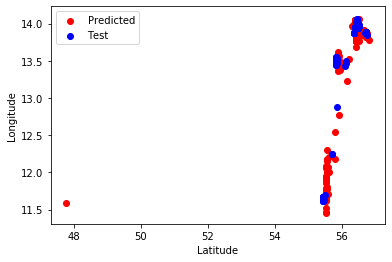

In [31]:
# create scatter plot
plt.scatter(y_lat_pred, y_long_pred, c='r', label='Predicted')
plt.scatter(y_lat_test, y_long_test, c='b', label='Test')

# add labels and legend
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

# show plot
plt.show()

In [32]:
X_test["population"].shape

(3983,)

In [33]:
y_lat_test_comb = pd.DataFrame(y_lat_test)
y_lat_test_comb.shape

(3983, 1)

In [34]:
y_long_test_comb = pd.DataFrame(y_long_test)
y_long_test_comb.shape

(3983, 1)

In [35]:
y_lat_pred_comb = pd.DataFrame(y_lat_pred)
y_lat_pred_comb.shape

(3983, 1)

In [36]:
y_long_pred_comb = pd.DataFrame(y_long_pred)
y_long_pred_comb.shape

(3983, 1)

In [37]:
pop_df = pd.DataFrame(X_test["population"].values.reshape(-1, 1))
pop_df.shape

(3983, 1)

In [38]:
# Create a dataframe with all the values, (predicted and actual), in order to be used for diagrams and comparisons.
combined_df = pd.concat([pop_df, y_lat_pred_comb, y_long_pred_comb, y_lat_test_comb, y_long_test_comb], axis=1)
combined_df.columns = ["population", "Pred_latitude", "Pred_longitude", "latitude", "longitude"]

In [39]:
combined_df = combined_df.dropna()

In [40]:
combined_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
0,71.0,56.450249,14.005757,56.439716,13.991791
3,88.0,56.438591,14.009343,56.441143,13.988527
6,131.0,56.451447,13.993893,56.439716,13.992242
17,27.0,56.425514,14.011176,56.439903,13.992476
19,23.0,56.425392,14.016939,56.439484,13.992446
31,67.0,56.431175,14.010034,56.439350,13.992638
34,24.0,56.414978,14.037573,56.440166,13.992716
35,131.0,56.448944,13.997207,56.439930,13.992993
41,152.0,56.463570,13.937330,56.440140,13.992735
42,152.0,56.479340,13.907372,56.440044,13.992678


In [41]:
#selecting the most frequent population of the populations that have more than 20 members.
threshold = 20
populations_above_threshold = combined_df['population'].value_counts()[combined_df['population'].value_counts() >= threshold].index
if len(populations_above_threshold) > 0:
    most_frequent_pop = combined_df.loc[combined_df['population'].isin(populations_above_threshold)]['population'].value_counts().idxmax()
    most_frequent_pop_df = combined_df.loc[combined_df['population'] == most_frequent_pop]
else:
    print("change the threshold!")


In [42]:
most_frequent_pop_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
41,152.0,56.463570,13.937330,56.440140,13.992735
42,152.0,56.479340,13.907372,56.440044,13.992678
181,152.0,56.459366,13.916655,56.440220,13.992155
218,152.0,56.465179,13.935094,56.440342,13.992517
257,152.0,56.161156,13.222604,56.439884,13.991575
449,152.0,56.425179,13.907897,56.439644,13.992051
466,152.0,56.490082,13.902841,56.439968,13.992618
836,152.0,56.505173,13.896060,56.439949,13.992587
1010,152.0,56.439926,13.924914,56.439953,13.993013
1063,152.0,56.484726,13.911860,56.439720,13.992579


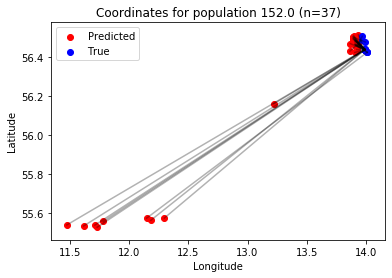

In [43]:
# Filter for rows with non-null predicted and true coordinates
filtered_df = most_frequent_pop_df.dropna(subset=['Pred_latitude', 'Pred_longitude', 'latitude', 'longitude'])

# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()


In [44]:
most_frequent_pop_df.shape

(37, 5)

In [45]:
# Removing outliers
filtered_df = filtered_df[(filtered_df['Pred_longitude'] >= 13.7) & (filtered_df['longitude'] >= 13.7)]

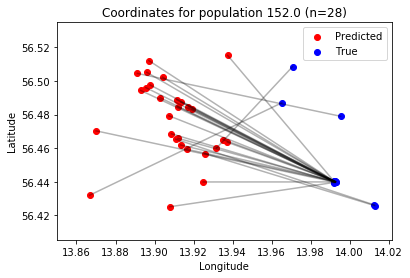

In [46]:
# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()

In [47]:
# Removing outliers
combined_df = combined_df[(combined_df['Pred_longitude'] >= 13.7) & (combined_df['longitude'] >= 13.7)]

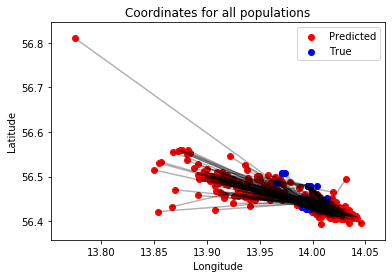

In [48]:
# Create scatter plot of predicted and true coordinates
plt.scatter(combined_df['Pred_longitude'], combined_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(combined_df['longitude'], combined_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in combined_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for all populations")

# Show plot
plt.show()